# Local Thickness

This example explains how to use the ``local_thicknes`` filter to get information about the pore size distribution from an image.  The local thickness is probably the closest you can get to an actual pore size distribution.  Unlike porosimetry experiments or simulations it is unaffected by artifacts such as edge effects.  The implementation in PoreSpy is slightly different than the common approach done in ImageJ, as will be explained below.

These notebooks were generated with a specific version of Python, PoreSpy, Numpy, etc.  For reference to future viewers, the version information is given below.  This notebook may or may not work with later versions, but we can assert it works with the version listed below:

In [1]:
import porespy as ps
import time
print("This notebook was last exectuted on " + time.strftime("%A %B %d %Y") + 
      " using Version " + ps.__version__ + " of PoreSpy")

This notebook was last exectuted on Saturday March 16 2019 using Version 1.0.1 of PoreSpy


Import the needed packages from the Scipy stack:

In [2]:
import numpy as np
import scipy.ndimage as spim
import matplotlib.pyplot as plt

## Generate Test Image
Start by generating an image.  We'll use the RSA generator for fun:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
RSA: Adding spheres of size 20
Volume Fraction 0.2 reached
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
RSA: Adding spheres of size 15
Volume Fraction 0.4 reached
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
RSA: Adding spheres of size 10
Volume Fraction 0.6 reached


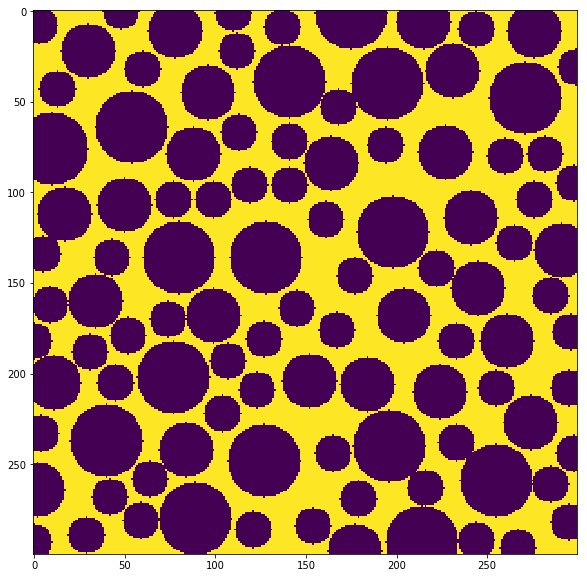

In [3]:
im = np.zeros([300, 300])
im = ps.generators.RSA(im, radius=20, volume_fraction=0.2)
im = ps.generators.RSA(im, radius=15, volume_fraction=0.4)
im = ps.generators.RSA(im, radius=10, volume_fraction=0.6)
im = im == 0
plt.figure(figsize=[10, 10])
fig = plt.imshow(im)

## Apply Local Thickness Filter
The local thickness filter is called by simply passing in the image.  Like all filters in PoreSpy it is applied to the foreground, indicated by 1's or ``True``:

100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 109.34it/s]


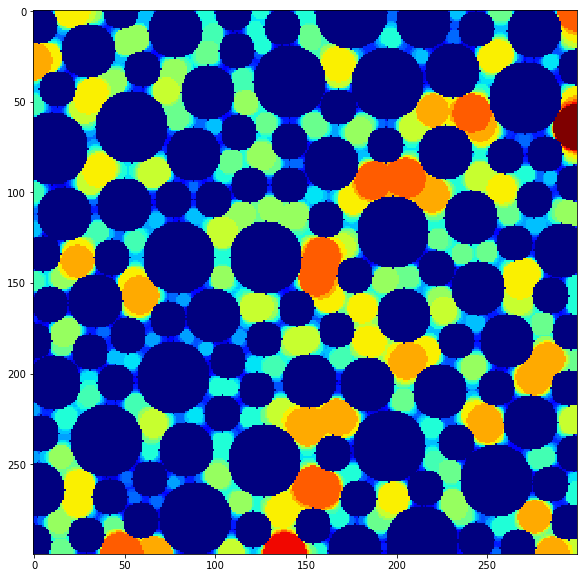

In [4]:
thk = ps.filters.local_thickness(im, mode='dt')
plt.figure(figsize=[10, 10])
fig = plt.imshow(thk, cmap=plt.cm.jet)

## Extracting PSD as a Histogram
Obtaining pore size distribution information from this image requires obtaining a histogram of voxel values.  A function in the ``metrics`` module does this for us:

In [5]:
psd = ps.metrics.pore_size_distribution(im=thk)

The result returned into ``psd`` is a "named-tuple", which is a list of arrays that can be accessed by location (i.e. ``psd[0]``), but has the added benefit of accessing arrays by name so you know what you're getting.  You can print a list of available arrays as follows:

In [6]:
print(psd._fields)

('logR', 'pdf', 'cdf', 'satn', 'bin_centers', 'bin_edges', 'bin_widths')


Let's plot a pore-size distribution histogram:

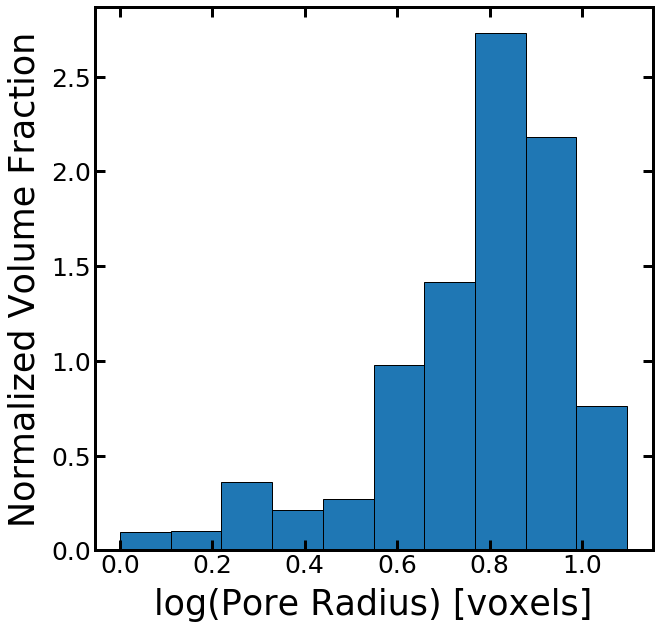

In [7]:
# Set figure styles using predefined args in PoreSpy
ps.visualization.set_mpl_style()
plt.figure(figsize=[10, 10])
plt.xlabel('log(Pore Radius) [voxels]')
plt.ylabel('Normalized Volume Fraction')
fig = plt.bar(x=psd.logR, height=psd.pdf, width=psd.bin_widths, edgecolor='k')

## PoreSpy Implementation
The ``local_thickness`` filter in PoreSpy is implemented differently that the *normal* approach such as the ImageJ plugin, though the end result is comparible though not identical.  

In our approach, we use a form of image dilation and erosion.  We start with a large spherical structuring element, and note all the places where this fits in the pore space.  This gives a result like that below for a structuring element of radius R=10:

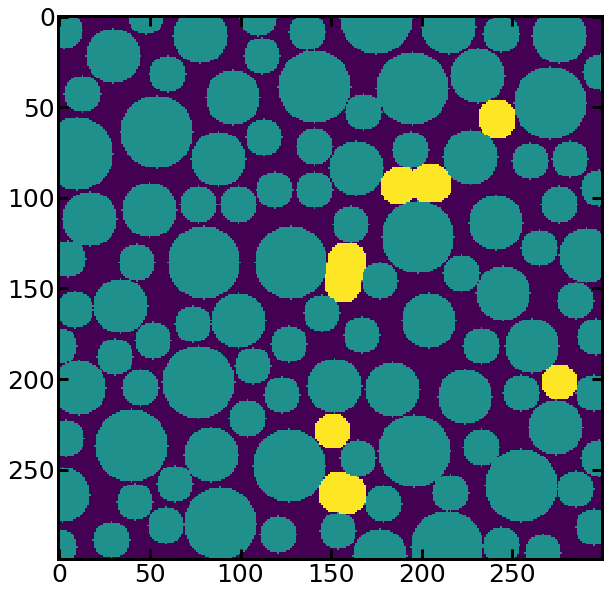

In [8]:
R = 10 
strel = ps.tools.ps_disk(R)
im_temp = spim.binary_opening(im, structure=strel)
plt.figure(figsize=[10, 10])
fig = plt.imshow(im_temp*2.0 + ~im)

The key is to make a *master* array containing the numerical value of the largest sphere that covers each voxel.  We'll initialize a new array with the current locations where R=10 fits:

In [9]:
im_result = im_temp*R

Now this is repeated for a range of decreasing structuring element sizes.  For illustration, do R = 8:

In [10]:
R = 8
strel = ps.tools.ps_disk(R)
im_temp = spim.binary_opening(im, structure=strel)

This new image must be added to the ``im_result`` array, but only in places that were not filled at any larger radius.  This is done using boolean logic as follows:

In [11]:
im_result[(im_result == 0)*im_temp] = R

There are now 2 values in the ``im_results`` array indicating the locations where the structuring element of size 10 fits, and where size 8 fit on the subsequent step:

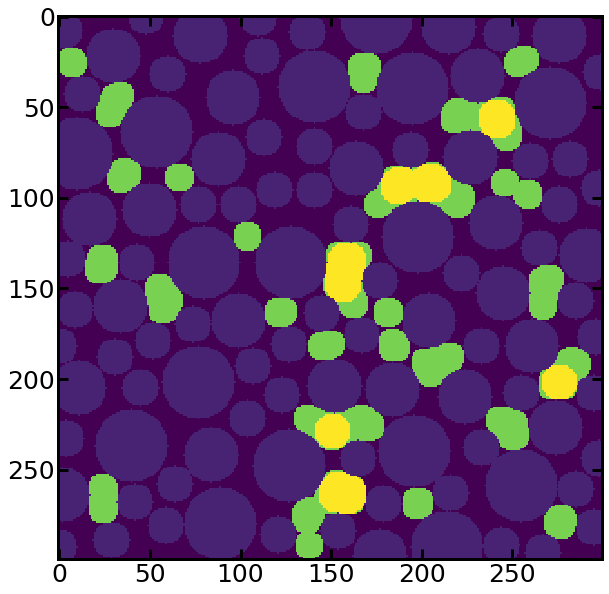

In [12]:
plt.figure(figsize=[10, 10])
fig = plt.imshow(im_result + ~im)

The procedure is then repeated for smaller structuring elements down to R = 1.  It's possible to specify which sizes are used, but by default all integers between $R_{max}$ and 1.  This yields the image showed above:

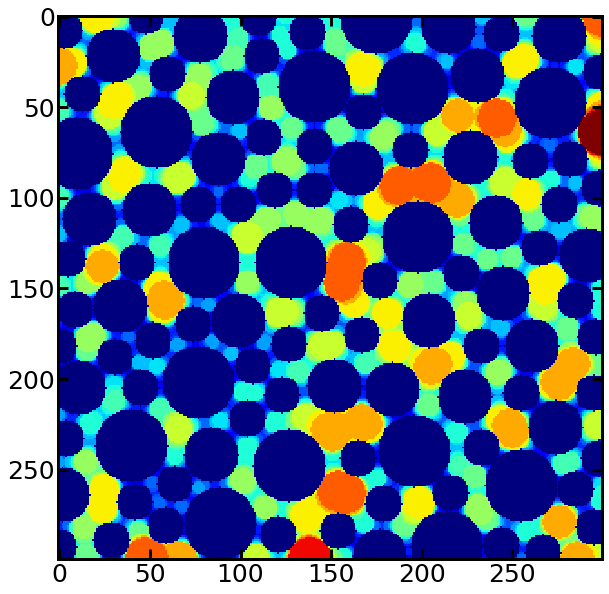

In [13]:
plt.figure(figsize=[10, 10])
fig = plt.imshow(thk, cmap=plt.cm.jet)